# Realistic Drag, Mass, and Velocity

**Example Broken**

This notebook section focuses on simulating cloud droplet-sized aerosol particles (around 100 microns) with accurate mass and velocity. Key improvements include:

1. **Refining Initial Conditions**: Setting precise starting values for particle mass and velocity.
2. **Modeling Forces Accurately**: Better representation of forces acting on particles to influence their movement.

These steps are crucial for enhancing the realism of the aerosol particle model.

In [1]:
# Code Section: Importing Necessary Libraries and Initializing Variables
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from particula.lagrangian import boundary, integration, collisions, particle_property, particle_pairs
from particula.util import machine_limit

device = torch.device('cuda') # or 'cuda:0' to specify a particular GPU
torch.set_default_device(device)


# Initializing the Torch Generator and setting the data type
seed = 1234
torch.manual_seed(seed)  # Set the seed for reproducibility
t_type = torch.float32

# print particula version
from particula import __version__
print("particula version: ", __version__)

particula version:  0.0.17.dev0


## Initialization of Particles

In this section, we'll enhance particle initialization for realism:
- **Particle Masses**: Implementing a narrow log-normal distribution to better represent real-world mass variation.
- **Particle Velocities**: Utilizing thermal velocity, influenced by Brownian motion, for initial velocity settings.
- **Initial Positions**: Particles will be randomly placed within a defined box area to simulate natural distribution.


In [ ]:
# Setting up the Simulation Parameters and Initial Conditions

# Define fixed parameters
TOTAL_NUMBER_OF_PARTICLES = 100
TIME_STEP = 0.005
SIMULATION_TIME = 10
CUBE_SIDE = 0.010  # Size of the simulation cube in meters
save_points = 120  # Number of points to save the simulation data
tke_sigma = 0.5  # Standard deviation of turbulent kinetic energy, m^2/s^2

# Defining new parameters for more realistic simulation
density_uniform = 1.5e3  # Uniform density of particles in kg/m^3
mean_radius_nm = 25000  # Mean radius of particles in nanometers
std_dev_nm = 1.1  # Standard deviation of particle radius in nanometers
system_temperature_kelvin = 300  # System temperature in Kelvin
system_pressure_pascal = 1e5  # System pressure in Pascal

# Define intervals for updating interaction factors
interval_friction_factor = 1000  # Interval for updating friction factor
interval_coagulation = 100  # Interval for updating coagulation
regnerate_interval = 10000  # Interval for regenerating particles
tke_interval = 100  # Interval for updating turbulent kinetic energy

# Generating particle masses using a log-normal distribution
mass = particle_property.generate_particle_masses(
    mean_radius=mean_radius_nm,
    std_dev_radius=std_dev_nm,
    density=density_uniform,
    num_particles=TOTAL_NUMBER_OF_PARTICLES,
    radius_input_units="nm",
)

# Initializing particle velocities using thermal velocity
velocity = particle_property.random_thermal_velocity(
    temperature_kelvin=system_temperature_kelvin,
    mass_kg=mass,
    number_of_particles=TOTAL_NUMBER_OF_PARTICLES,
    t_type=t_type,
    random_seed=seed
)

# Setting constant density for all particles
density = torch.ones(TOTAL_NUMBER_OF_PARTICLES, dtype=t_type) * density_uniform

# Initialize particle positions randomly within the cube
position = torch.rand(
    3,
    TOTAL_NUMBER_OF_PARTICLES,
    dtype=t_type) * CUBE_SIDE - CUBE_SIDE / 2

# Initialize force as zero for all particles
force = torch.zeros(3, TOTAL_NUMBER_OF_PARTICLES, dtype=t_type)

# Generating indices for particles
indices = torch.arange(TOTAL_NUMBER_OF_PARTICLES, dtype=t_type)  # Integer type

# Calculating the total number of iterations for the simulation
total_iterations = int(SIMULATION_TIME / TIME_STEP)

# Initializing tensor to track total mass over iterations
total_mass = torch.zeros(total_iterations, dtype=t_type)

# Defining gravity acting on all particles
gravity = torch.tensor(
    [0, 0, -9.81]).repeat(TOTAL_NUMBER_OF_PARTICLES, 1).transpose(0, 1)

# Initializing Arrays for Saving Position and Mass Data
save_position = np.zeros((3, TOTAL_NUMBER_OF_PARTICLES, save_points))
save_mass = np.zeros((TOTAL_NUMBER_OF_PARTICLES, save_points))
save_iterations = np.linspace(0, total_iterations, save_points, dtype=int)

# Calculating particle radius from mass and density
radius = particle_property.radius_calculation(mass=mass, density=density)

In [ ]:
# random air velcoity TKE generation
air_velocity_length = total_iterations//tke_interval
normal_dist = torch.distributions.normal.Normal(0, tke_sigma)
air_velocities = normal_dist.sample((3, air_velocity_length))

# Calculating the initial turbulent kinetic energy
def tke_calculation(air_velocities):
    """Calculates the turbulent kinetic energy from air velocity"""
    std_velocities = torch.std(air_velocities, dim=1)
    tke = 0.5 * sum(std_velocities**2)
    return tke

tke = tke_calculation(air_velocities)
print("Initial TKE: ", tke)
print("velocity shape: ", air_velocities.shape)
print("Air initial velocity: ", air_velocities[:, 0])


Initial TKE:  tensor(0.3742)
velocity shape:  torch.Size([3, 86400])
Air initial velocity:  tensor([ 0.3003, -0.4218, -0.4296])


## Plotting Initial Conditions

To verify the realism of our particle model, we'll plot the initial distributions of particle size and velocity. This step ensures that the initial setup aligns with our expectations and the intended simulation parameters.

### Particle Size Distribution
First, we examine the distribution of particle radii. The goal is to confirm that the radii follow the specified log-normal distribution.

### Particle Velocity Distribution
Next, we assess the distribution of particle velocities. This is crucial for ensuring that the initial velocities reflect thermal motion as intended.


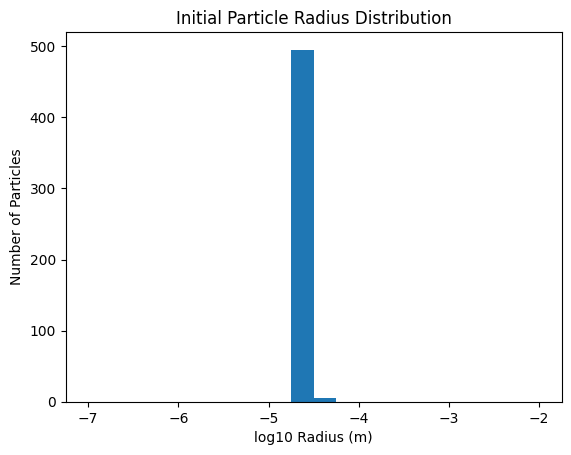

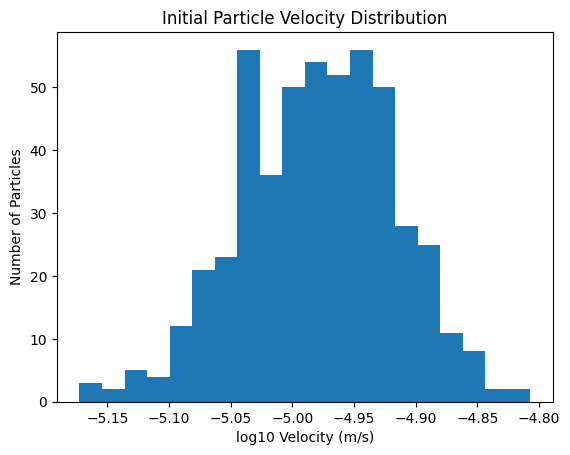

In [ ]:
# Plotting the Initial Radius Distribution

# Calculate the initial radius of particles
radius_initial = particle_property.radius_calculation(
    mass=mass, density=density)

# Plotting the histogram for radius distribution
fig, ax = plt.subplots()
ax.hist(machine_limit.safe_log10(radius_initial), bins=20, range=(-7, -2))
ax.set_xlabel("log10 Radius (m)")
ax.set_ylabel("Number of Particles")
ax.set_title("Initial Particle Radius Distribution")
plt.show()

# Plotting the Initial Velocity Distribution

# Calculate the speeds of particles from their velocities
initial_speeds = particle_property.speed(velocity)

# Plotting the histogram for velocity distribution
fig, ax = plt.subplots()
ax.hist(machine_limit.safe_log10(initial_speeds), bins=20)
ax.set_xlabel("log10 Velocity (m/s)")
ax.set_ylabel("Number of Particles")
ax.set_title("Initial Particle Velocity Distribution")
plt.show()

Initial Max Diameter [mm]:  0.06673528696410358
Initial Min Diameter [mm]:  0.03808399196714163


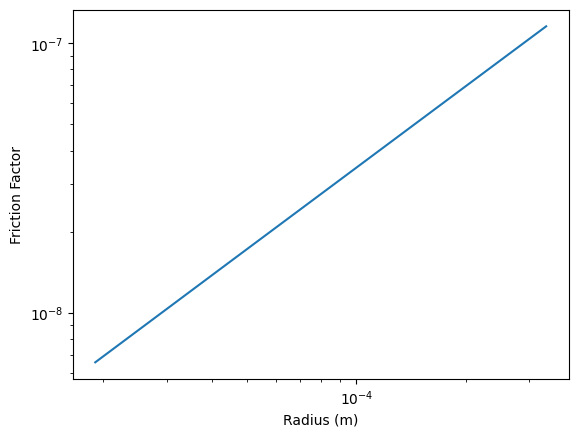

In [ ]:
# Printing the Maximum and Minimum Radii of the Particles
print("Initial Max Diameter [mm]: ", radius_initial.max().item() * 2 * 1e3)
print(
    "Initial Min Diameter [mm]: ",
    radius_initial.min().item() *
    2 *
    1e3)

# Initializing the Range of Radii for Friction Factor Calculation
# We use a linspace to cover a range from the smallest to 10 times the
# largest radius.
friction_factor_radius = torch.linspace(
    start=radius.min(),
    end=radius.max() * 10,
    steps=1000,
)

# Calculating the Friction Factor
# This calculation considers the radius, temperature, and pressure to
# determine the friction factor.
friction_factor_array = particle_property.friction_factor_wrapper(
    radius_meter=friction_factor_radius,
    temperature_kelvin=system_temperature_kelvin,
    pressure_pascal=system_pressure_pascal,
)

# Plotting Friction Factor vs Radius
# The plot helps in visualizing how friction factor varies with particle
# radius.
fig, ax = plt.subplots()
ax.plot(friction_factor_radius, friction_factor_array)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Radius (m)")
ax.set_ylabel("Friction Factor")
plt.show()

## Running the Particle Simulation

In this part of the notebook, we execute the core simulation loop. This involves integrating the motion of the particles over time while considering the forces acting on them, including friction and gravity. Several key updates and optimizations are included:

1. **Friction Factor Initialization**: Before entering the main loop, the friction factor for each particle is calculated. This is an essential step for accurately simulating the drag force on particles.

2. **Conditional Coagulation Step**: The simulation includes an optional coagulation step, executed at a specified interval. This step simulates the merging of particles upon collision, affecting their mass and velocity.

3. **Friction Factor Update**: The friction factor is updated at regular intervals to reflect changes in particle size or other environmental conditions. This step ensures that the drag force remains accurate throughout the simulation.

4. **Force Calculation and Integration**: Within each iteration, we calculate the forces acting on the particles and update their positions and velocities using the leapfrog integration method.

5. **Boundary Conditions and Data Saving**: The simulation includes boundary conditions to mimic a wrapped cube environment. Additionally, particle position and mass data are saved at predefined intervals for analysis.

This simulation loop provides a comprehensive and dynamic model of particle motion, taking into account physical factors and interactions.

In [ ]:
# Initialize Counter for Saving Data and Start Timer
save_counter = 0
start_time = time.time()

# Initial Calculations Before Starting the Simulation Loop
radius = particle_property.radius_calculation(mass=mass, density=density)
friction_factor_iter = particle_property.nearest_match(
    x_values=friction_factor_radius,
    y_values=friction_factor_array,
    x_new=radius,
)

# regeneration of radius and velocity
regen_radius = radius.clone()
regen_velocity = velocity.clone()
regen_mass = mass.clone()
air_ones = torch.ones((3, TOTAL_NUMBER_OF_PARTICLES))
air_velocity = air_ones*air_velocities[:, 0].unsqueeze(1)

# Main Simulation Loop
for i in range(total_iterations):

    # Coagulation Step (Optional, based on specified interval)
    if i % interval_coagulation == 0:
        # Update radius for collision detection
        radius = particle_property.radius_calculation(
            mass=mass, density=density)
        # Detect potential collision pairs
        valid_collision_indices_pairs = particle_pairs.full_sweep_and_prune(
            position=position, radius=radius)

        # Process collisions and update particle properties
        if valid_collision_indices_pairs.shape[0] > 0:
            velocity, mass = collisions.coalescence(
                position=position,
                velocity=velocity,
                mass=mass,
                radius=radius,
                collision_indices_pairs=valid_collision_indices_pairs)

    if i % regnerate_interval == 0:
        # regenerate for constant particle number
        zero_mass_bool = mass == 0
        radius[zero_mass_bool] = regen_radius[zero_mass_bool]
        velocity[:, zero_mass_bool] = regen_velocity[:, zero_mass_bool]
        mass[zero_mass_bool] = regen_mass[zero_mass_bool]

    if i % tke_interval == 0:
        # regenerate air velocity
        air_velocity = air_ones*air_velocities[:, i//tke_interval].unsqueeze(1)

    # Update Friction Factor (Optional, based on specified interval)
    if i % interval_friction_factor == 0:
        radius = particle_property.radius_calculation(
            mass=mass, density=density)
        friction_factor_iter = particle_property.nearest_match(
            x_values=friction_factor_radius,
            y_values=friction_factor_array,
            x_new=radius,
        )

    # Calculate Forces (including updated friction factor)
    force = mass * gravity + (air_velocity - velocity) * friction_factor_iter

    # Integrate Equations of Motion (Leapfrog Method)
    position, velocity = integration.leapfrog(
        position=position, velocity=velocity, force=force, mass=mass, time_step=TIME_STEP)

    # Apply Boundary Conditions (Cube Wrap-around)
    position = boundary.wrapped_cube(position=position, cube_side=CUBE_SIDE)

    # Save Data at Predefined Intervals
    if i == save_iterations[save_counter]:
        save_position[:, :, save_counter] = position.detach().numpy()
        save_mass[:, save_counter] = mass.detach().numpy()
        save_counter += 1
        print(f"Saving data at iteration {i} of {total_iterations}")

# Final Data Save and Calculation of Total Simulation Time
save_position[:, :, -1] = position.detach().numpy()
save_mass[:, -1] = mass.detach().numpy()
end_time = time.time()
print(f"Total wall time: {end_time - start_time} seconds")
print(
    f"Ratio of wall time to simulation time: {(end_time - start_time) / SIMULATION_TIME}")



Saving data at iteration 0 of 8640000
Saving data at iteration 72605 of 8640000
Saving data at iteration 145210 of 8640000
Saving data at iteration 217815 of 8640000
Saving data at iteration 290420 of 8640000
Saving data at iteration 363025 of 8640000
Saving data at iteration 435630 of 8640000
Saving data at iteration 508235 of 8640000
Saving data at iteration 580840 of 8640000
Saving data at iteration 653445 of 8640000
Saving data at iteration 726050 of 8640000
Saving data at iteration 798655 of 8640000
Saving data at iteration 871260 of 8640000
Saving data at iteration 943865 of 8640000
Saving data at iteration 1016470 of 8640000
Saving data at iteration 1089075 of 8640000
Saving data at iteration 1161680 of 8640000
Saving data at iteration 1234285 of 8640000
Saving data at iteration 1306890 of 8640000
Saving data at iteration 1379495 of 8640000
Saving data at iteration 1452100 of 8640000
Saving data at iteration 1524705 of 8640000
Saving data at iteration 1597310 of 8640000
Saving d

In [ ]:
# save data
np.savez_compressed(
    "data_tke.npz",
    position=save_position,
    mass=save_mass,
    iterations=save_iterations,
    time_step=TIME_STEP,
    total_iterations=total_iterations,
    total_number_of_particles=TOTAL_NUMBER_OF_PARTICLES,
    simulation_time=SIMULATION_TIME,
    cube_side=CUBE_SIDE,
    density_uniform=density_uniform,
    mean_radius_nm=mean_radius_nm,
    std_dev_nm=std_dev_nm,
    system_temperature_kelvin=system_temperature_kelvin,
    system_pressure_pascal=system_pressure_pascal,
    interval_friction_factor=interval_friction_factor,
    interval_coagulation=interval_coagulation,
    seed=seed,
    friction_factor_radius=friction_factor_radius,
    friction_factor_array=friction_factor_array,
)

## Plotting Particle Positions

After running the simulation, we'll plot the particle positions to visualize their movement. 

Number of particles at the end: 500


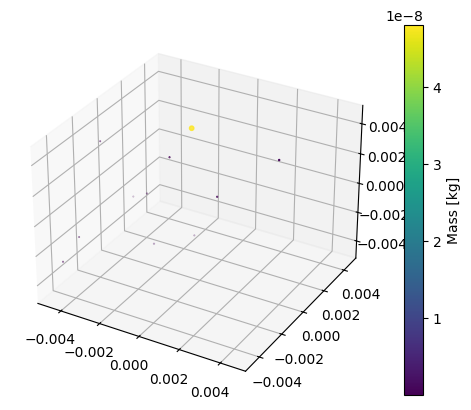

In [ ]:
# Processing the Final Data for Visualization

# Select the final time index for the data
time_index = -1
position_final = save_position[:, :, time_index]
mass_final = save_mass[:, time_index]

# Filter out particles with zero mass
filter_zero_mass = mass_final > 0

# Calculate the radius and area of each particle
radius_final = particle_property.radius_calculation(mass=mass_final, density=density)
particle_area = np.pi * radius_final**2
# normalize the area
particle_area = particle_area / particle_area.max()


# Display the number of remaining particles
print(f"Number of particles at the end: {filter_zero_mass.sum()}")

# Creating a 3D Plot for Visualization
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Choose a color map for the scatter plot
cmap = plt.cm.viridis

# Plot the final positions of particles with non-zero mass
scatter_plot = ax.scatter(
    position_final[0, filter_zero_mass],
    position_final[1, filter_zero_mass],
    position_final[2, filter_zero_mass],
    c=mass_final[filter_zero_mass],
    cmap=cmap,
    s=particle_area[filter_zero_mass]*10 # scalled Particle size based on normalized area
)

# # Set axis limits based on cube dimensions
ax.set_xlim(-CUBE_SIDE / 2, CUBE_SIDE / 2)
ax.set_ylim(-CUBE_SIDE / 2, CUBE_SIDE / 2)
ax.set_zlim(-CUBE_SIDE / 2, CUBE_SIDE / 2)

# Add a color bar indicating particle mass
color_bar = plt.colorbar(scatter_plot, ax=ax)
color_bar.set_label('Mass [kg]')

# Show the plot with optimized layout
plt.show()
fig.tight_layout()


 ## Size Distribution of Particles

Given particle collision and coagulation, we'll plot the distribution of particle sizes at the end of the simulation. This step ensures that the particle size distribution aligns with our expectations and the intended simulation parameters. That being, both a decrease in the number of particles and an increase in the average particle size.

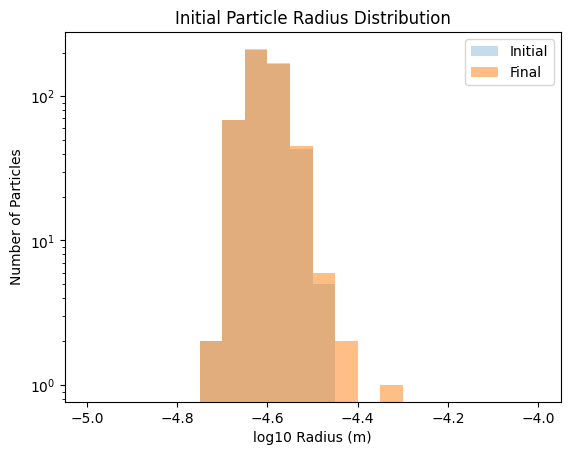

Initial Max Diameter [mm]:  0.06673528696410358
Final Max Diameter [mm]:  0.3941673396242591


In [ ]:
# Visualizing the Mass Distribution at Different Stages

# plot initial radius distribution
fig, ax = plt.subplots()
ax.hist(machine_limit.safe_log10(radius_initial), bins=20, range=(-5,-4), label="Initial", alpha=0.25)
ax.hist(machine_limit.safe_log10(radius_final[filter_zero_mass]), bins=20, range=(-5,-4), label="Final", alpha=0.5)
ax.set_yscale("log")
ax.set_xlabel("log10 Radius (m)")
ax.set_ylabel("Number of Particles")
ax.set_title("Initial Particle Radius Distribution")
ax.legend()
plt.show()

print("Initial Max Diameter [mm]: ", radius_initial.max().item()*2*1e3)
print("Final Max Diameter [mm]: ", radius_final[filter_zero_mass].max().item()*2*1e3)